Lets model a single quadrant for now.  Start with a "true" ra/dec of a set of stars filling the space of a quadrant. Assume the origin is ra=dec=0 deg.

In [1]:
import numpy as np

from astropy import units as u

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [18]:
nstars = 100
catalog_unc = 50*u.marcsec
spatial_unc = 200*u.marcsec

slit_frac = .5 # fraction of the slit that the catalog can select in

offset_scale = 0.1*u.arcsec

In [4]:
shutter_dispersion_len = 0.2*u.arcsec
shutter_spatial_len = 0.46*u.arcsec
shutter_wall_len = 0.07*u.arcsec

shutter_dispersion_n = 365
shutter_spatial_n = 171

q_dispersion_size = shutter_dispersion_len*shutter_dispersion_n+(shutter_dispersion_n+1)*shutter_wall_len
q_spatial_size = shutter_spatial_len*shutter_spatial_n+(shutter_spatial_n+1)*shutter_wall_len

q_dispersion_size,q_spatial_size

(<Quantity 98.62 arcsec>, <Quantity 90.7 arcsec>)

In [5]:
(q_dispersion_size*2 + 23*u.arcsec).to(u.arcmin)

<Quantity 3.67066667 arcmin>

In [6]:
(q_spatial_size*2 + 37*u.arcsec).to(u.arcmin)

<Quantity 3.64 arcmin>

Hmm, these numbers don't perfectly match https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-micro-shutter-assembly but they're pretty close so lets just go with it

In [7]:
ra_true, dec_true = (np.random.rand(2, int(nstars*50/slit_frac))*2 - .5)  * max(q_spatial_size, q_dispersion_size)
# bigger than the quadrant by 1.8 and not starting at origin, but that's OK because we will allow for some rotation

In [8]:
ra_catalog = ra_true + np.random.randn(ra_true.size)*catalog_unc
dec_catalog = dec_true + np.random.randn(dec_true.size)*catalog_unc

Now select `nstars` in the inner `slit_frac` of each slit

In [9]:
slit_centers_dispersion = np.arange(shutter_dispersion_n)*(shutter_wall_len+shutter_dispersion_len)+ shutter_wall_len + shutter_dispersion_len/2
slit_centers_spatial = np.arange(shutter_spatial_n)*(shutter_wall_len+shutter_spatial_len)+ shutter_wall_len + shutter_spatial_len/2

In [10]:
pa = 30*u.deg
c = np.cos(pa)
s = np.sin(pa)

dispersion_catalog = ra_catalog*c - dec_catalog*s
spatial_catalog = ra_catalog*s + dec_catalog*c

353

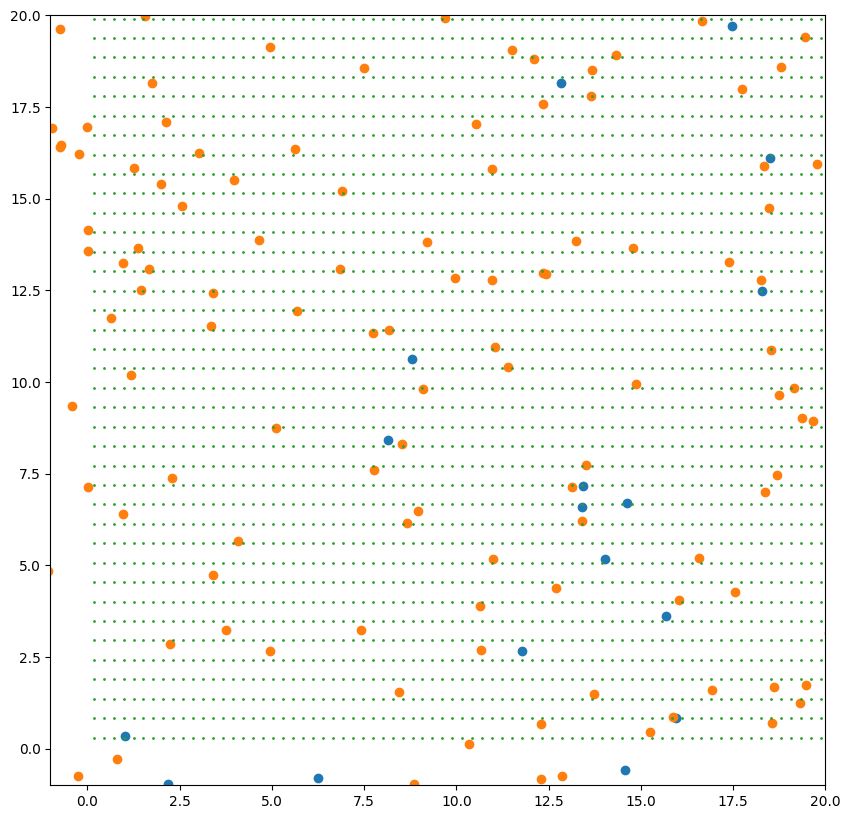

In [11]:
selected_idxs = []
rejected_idxs = []
ddisps = []
dspatials = []
for i, (disp, spatial) in enumerate(zip(dispersion_catalog, spatial_catalog)):
    ddisp = disp - slit_centers_dispersion
    ddisps.append(ddisp[np.argmin(np.abs(ddisp))])
    
    dspatial = spatial - slit_centers_spatial
    dspatials.append(dspatial[np.argmin(np.abs(dspatial))])
    
    if (np.abs(ddisps[-1]) < shutter_dispersion_len*slit_frac/2) and (np.abs(dspatials[-1]) < shutter_spatial_len*slit_frac/2):
        selected_idxs.append(i)
    else:
        rejected_idxs.append(i)
ddisps = u.Quantity(ddisps)
dspatials = u.Quantity(dspatials)

selected_msk = np.zeros(len(ra_catalog), dtype=bool)
selected_msk[np.array(selected_idxs)] = True

plt.figure(figsize=(10, 10))
plt.scatter(ra_catalog[selected_msk], dec_catalog[selected_msk])
plt.scatter(ra_catalog[~selected_msk], dec_catalog[~selected_msk])

x, y = np.meshgrid(slit_centers_dispersion, slit_centers_spatial)
plt.scatter(x.ravel(), y.ravel(), s=1)
plt.xlim(-1, 20)
plt.ylim(-1, 20)   

assert np.sum(selected_msk)>nstars
np.sum(selected_msk)

In [12]:
target_ras = ra_catalog[selected_msk][:nstars]
target_decs = dec_catalog[selected_msk][:nstars]

target_disp_off = ddisps[selected_msk][:nstars]
target_spatial_off = dspatials[selected_msk][:nstars]

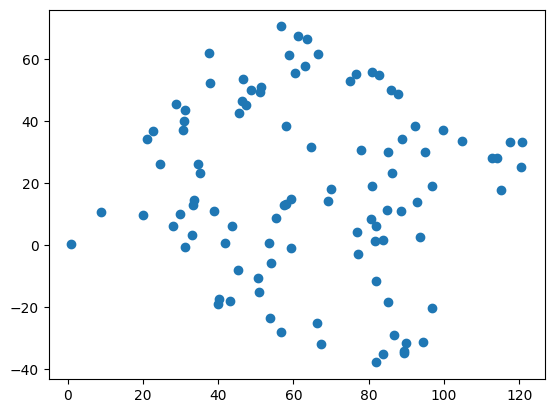

In [13]:
plt.scatter(target_ras, target_decs);

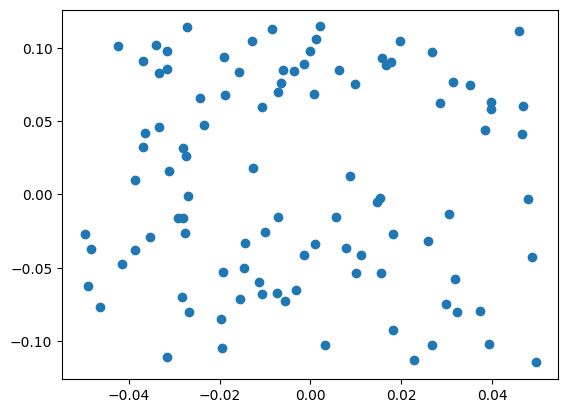

In [14]:
plt.scatter(target_disp_off, target_spatial_off);

In [20]:
raoffset, decoffset = np.random.randn(2)*offset_scale

target_apparent_ras = target_ras + raoffset
target_apparent_decs = target_decs + decoffset